In [80]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold

%matplotlib inline

In [678]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [679]:
test_id = test_data.Id

In [680]:
train_data = train_data.drop(['Id'] , axis = 1)

test_data = test_data.drop(['Id'] , axis = 1)

In [681]:
largest_10_corr_matrix = corr_matrix.nlargest(10 , 'SalePrice')
largest_10_corr_matrix_index = largest_10_corr_matrix.index #largest corr
largest = train_data[largest_10_corr_matrix_index].corr()

largest_10_corr_matrix_index = list(set(largest_10_corr_matrix_index)-set(['GarageArea' , '1stFlrSF']))

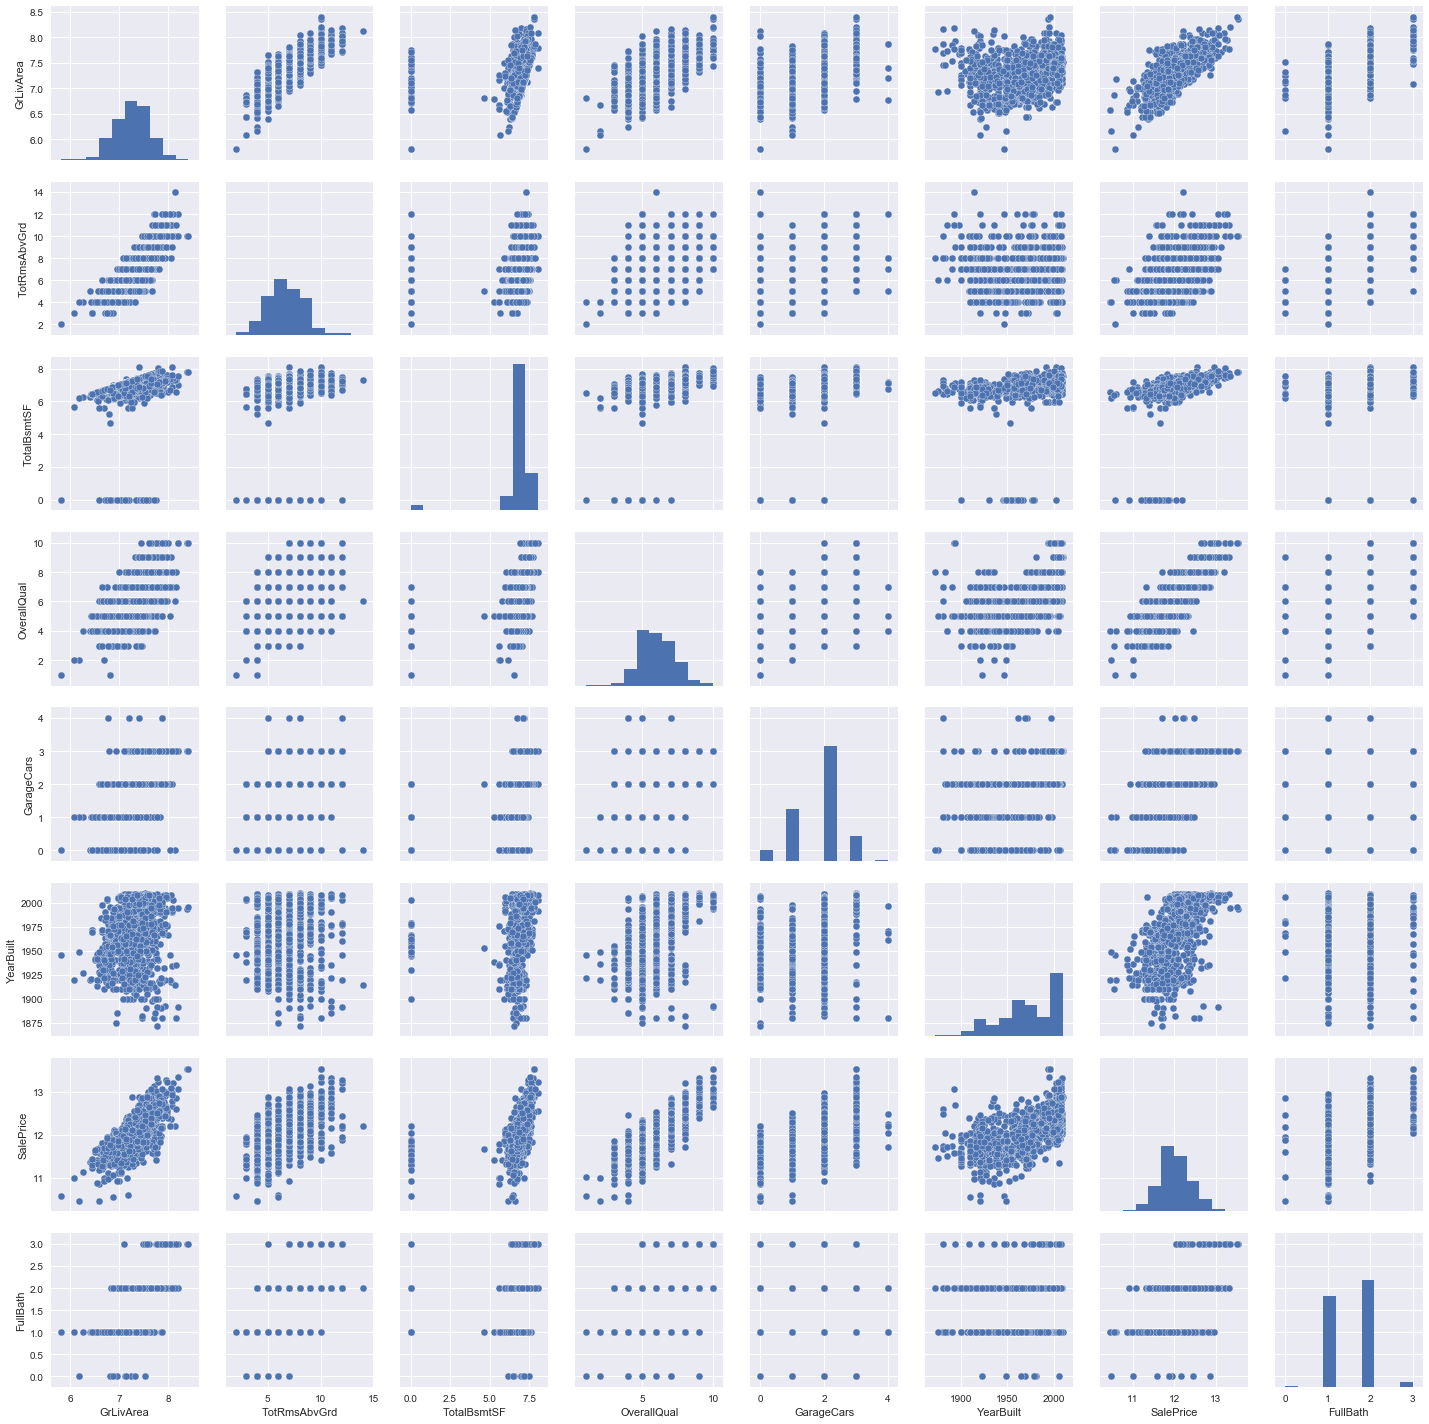

In [650]:
#plt.scatter(train_data.GrLivArea , train_data.SalePrice)
sns.pairplot(train_data[largest_10_corr_matrix_index])

In [635]:
train_data.loc[train_data.GrLivArea>4500,'GrLivArea'].index #找离群点

Int64Index([523, 1298], dtype='int64')

In [682]:
train_data = train_data.drop([523])

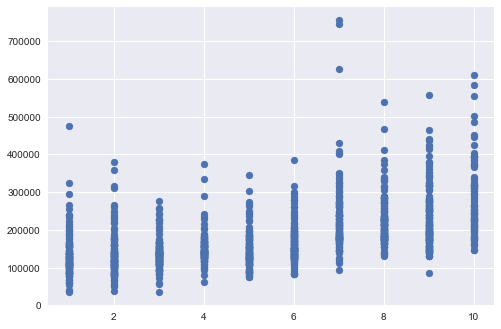

In [688]:
plt.scatter(train_data.YearBuilt , train_data.SalePrice)

In [683]:
categorical_index_yearbuilt = pd.qcut(train_data.YearBuilt , 10).value_counts().index

In [686]:
train_data.loc[ (train_data.YearBuilt>1871.999) & (train_data.YearBuilt<=1924.7)  , 'YearBuilt'] = 1
train_data.loc[ (train_data.YearBuilt>1924.7) & (train_data.YearBuilt<=1947.4)  , 'YearBuilt'] = 2
train_data.loc[ (train_data.YearBuilt>1947.4) & (train_data.YearBuilt<=1958.0)  , 'YearBuilt'] = 3
train_data.loc[ (train_data.YearBuilt>1958.0) & (train_data.YearBuilt<=1965.0)  , 'YearBuilt'] = 4
train_data.loc[ (train_data.YearBuilt>1965.0) & (train_data.YearBuilt<=1972.5)  , 'YearBuilt'] = 5
train_data.loc[ (train_data.YearBuilt>1972.5) & (train_data.YearBuilt<=1984.0)  , 'YearBuilt'] = 6
train_data.loc[ (train_data.YearBuilt>1984.0) & (train_data.YearBuilt<=1997.0)  , 'YearBuilt'] = 7
train_data.loc[ (train_data.YearBuilt>1997.0) & (train_data.YearBuilt<=2003.0)  , 'YearBuilt'] = 8
train_data.loc[ (train_data.YearBuilt>2003.0) & (train_data.YearBuilt<=2006.0)  , 'YearBuilt'] = 9
train_data.loc[ (train_data.YearBuilt>2006.0) & (train_data.YearBuilt<=2010.0)  , 'YearBuilt'] = 10


In [687]:
train_data[['YearBuilt' , 'SalePrice']].groupby('YearBuilt' ,as_index = False).mean()

,YearBuilt,SalePrice
0,1,131820.212329
1,2,133896.609589
2,3,136502.610778
3,4,151741.717557
4,5,146891.935252
5,6,165107.366013
6,7,229669.785714
7,8,223080.271605
8,9,232039.529730
9,10,284354.955556


In [637]:
train_data.loc[train_data.TotalBsmtSF>6000].index

Int64Index([1298], dtype='int64')

In [689]:
train_data = train_data.drop(1298)

In [690]:
missing_delete_feature = train_data.columns[train_data.isnull().sum().values > 1] #找含有缺失值的feature

train_data = train_data.drop(missing_delete_feature , axis = 1)

test_data = test_data.drop(missing_delete_feature , axis = 1)

In [691]:
object_columns = []
for i in train_data.columns:
    if train_data[i].dtype == object:
        object_columns.append(i)
        
features = largest_10_corr_matrix_index + object_columns

In [692]:
features.remove('SalePrice') #使用的features 将相关性不强的feature去掉

In [693]:
for i in test_data.columns:
    if test_data[i].isnull().sum() > 0:
        if test_data[i].dtype == object:
            test_data[i] = test_data[i].fillna(test_data[i].value_counts().sort_values(ascending = False).index[0])
        else:
            test_data[i] = test_data[i].fillna(test_data[i].mean())


In [694]:
print(test_data.shape)
print(train_data.shape)


(1459, 61)
(1458, 62)


In [695]:
train_data.Electrical = train_data.Electrical.fillna('SBrkr')

test_data.Electrical = test_data.Electrical.fillna('SBrkr')

In [696]:
#除偏
train_data.GrLivArea = train_data.GrLivArea.apply(np.log)
train_data.SalePrice = train_data.SalePrice.apply(np.log)

test_data.GrLivArea = test_data.GrLivArea.apply(np.log)

In [697]:
#train_data['flag'] = pd.Series(len(train_data.TotalBsmtSF) , index=train_data.index)
#train_data['flag'] = 0
#train_data.loc[train_data['TotalBsmtSF'] > 0 , 'flag'] = 1
#train_data.loc[train_data.flag == 1 , 'TotalBsmtSF'] = np.log(train_data.TotalBsmtSF)

train_data['HasBsmt'] = pd.Series(len(train_data['TotalBsmtSF']) , index=train_data.index)
train_data['HasBsmt'] = 0
train_data.loc[train_data['TotalBsmtSF']>0 , 'HasBsmt'] = 1

train_data.loc[train_data['HasBsmt']==1 , 'TotalBsmtSF'] = np.log(train_data.TotalBsmtSF)
#===============
test_data['HasBsmt'] = pd.Series(len(test_data['TotalBsmtSF']) , index=test_data.index)
test_data['HasBsmt'] = 0
test_data.loc[test_data['TotalBsmtSF']>0 , 'HasBsmt'] = 1

test_data.loc[test_data['HasBsmt']==1 , 'TotalBsmtSF'] = np.log(test_data.TotalBsmtSF)

I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [698]:
train_data = train_data.drop('HasBsmt' , axis =1)

test_data = test_data.drop('HasBsmt' , axis =1)

In [699]:
for i in test_data.columns:
    if test_data[i].dtype == object:
        a=list(test_data[i].value_counts().index)
        b=len(a)
        c= [i+1 for i in range(b)]
        d=dict(zip(a,c))
        test_data[i] = test_data[i].map(d)

In [700]:
for i in train_data.columns:
    if train_data[i].dtype == object:
        a=list(train_data[i].value_counts().index)
        b=len(a)
        c= [i+1 for i in range(b)]
        d=dict(zip(a,c))
        train_data[i] = train_data[i].map(d)

In [ ]:
#==================
#==================
#==================
#==================

In [420]:
#train_data = pd.get_dummies(train_data)

#test_data = pd.get_dummies(test_data)

In [701]:
train_label = train_data.SalePrice
train_data = train_data.drop('SalePrice' , axis = 1)

In [702]:
forest = RandomForestRegressor(n_estimators=100)
kf = KFold(train_data.shape[0] , 10 , True)
#forest.fit(train_data , train_label)

In [713]:
def rmse(model , data , label):
    #cv=5 分为5folds
    #在这里会对模型进行训练 
    return np.sqrt(-cross_val_score(model, data, label, scoring="neg_mean_squared_error", cv = 2))

In [714]:
rmse(forest , train_data[features] , train_label)

array([0.15737957, 0.14424922])

In [706]:
forest.fit(train_data[features] , train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [707]:
forest.score(train_data[features] , train_label)

0.9812097160879221

In [500]:
#进行预测
result = forest.predict(test_data)
result = np.exp(result)
result_csv = pd.DataFrame({'Id':test_id , 'SalePrice':result})
result_csv.to_csv('submit2.csv' , index=False)